In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
import torch
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import itertools

def collect_columns(dicts):
    # Initialize an empty dictionary to store the result
    result = {}

    # Loop over each dictionary in the list
    for d in dicts:
        # Loop over each key in the current dictionary
        for key in d.keys():
            # If the key is not already in the result, add it with an empty list
            if key not in result:
                result[key] = [None]*len(dicts)

        # Loop over each key in the result
        for key in result.keys():
            # If the key is in the current dictionary, add its value to the list
            # If not, add None
            if key in d:
                result[key][dicts.index(d)] = d[key]

    # Return the result
    return result


def merge_files(dir_path, skip_pt=True):
    # Initialize an empty dictionary to store the result
    result = {}

    # Walk through the directory
    for file in (os.listdir(dir_path)):
        # Check if the file has one of the required extensions
        if file.endswith(('.pickle', '.p')) or (file.endswith('.pt') and not skip_pt):
            # Construct the full file path
            file_path = os.path.join(dir_path, file)

            # Load the file content
            if file.endswith('.pt'):
                content = {'model_state': torch.load(file_path)}
            else:  # '.pickle' or '.p'
                with open(file_path, 'rb') as f:
                    content = pickle.load(f)

            # If the content is a dictionary, merge it with the result
            # Otherwise, add it under its filename
            if isinstance(content, dict):
                result.update(content)
            else:
                result[file] = content

    # Return the result
    return result


In [2]:
tags = ['test_basic_network_control']
data_dicts = []
for t in tags:
	cur_path = os.path.join('data',t)
	for f_p in os.listdir(cur_path):
		data_path=os.path.join(cur_path,f_p)
		data_dicts.append(merge_files(data_path))
data = collect_columns(data_dicts)
df = pd.DataFrame(data)
df = df.dropna(subset=['performance_mat.p'])

df


,seed_number,entropy_dependent_lr,homogeneous_lr,tag,n_task,batch_size,n_steps,n_epochs,num_workers,model_hidden_sizes,n_f_epochs,n_f_steps,lr,dir_name,dest_path,performance_mat.p
37,92959.0,False,True,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,0.01,d_43_3367,data/test_basic_network_control/d_43_3367,"[[0.4918999969959259, 0.0, 0.0, 0.0, 0.0, 0.0,..."
39,71578.0,False,True,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,0.01,d_45_9537,data/test_basic_network_control/d_45_9537,"[[0.5860999822616577, 0.0, 0.0, 0.0, 0.0, 0.0,..."
40,89670.0,False,True,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,0.01,d_46_8047,data/test_basic_network_control/d_46_8047,"[[0.30790001153945923, 0.0, 0.0, 0.0, 0.0, 0.0..."
42,71578.0,False,False,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,NaN,d_48_4078,data/test_basic_network_control/d_48_4078,"[[0.7680000066757202, 0.0, 0.0, 0.0, 0.0, 0.0,..."
49,62737.0,False,True,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,0.01,d_54_8963,data/test_basic_network_control/d_54_8963,"[[0.9162999987602234, 0.0, 0.0, 0.0, 0.0, 0.0,..."
50,17018.0,False,True,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,0.01,d_55_3116,data/test_basic_network_control/d_55_3116,"[[0.477400004863739, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
51,20312.0,False,False,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,NaN,d_56_1975,data/test_basic_network_control/d_56_1975,"[[0.6644999980926514, 0.0, 0.0, 0.0, 0.0, 0.0,..."
52,20312.0,False,True,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,0.01,d_57_8177,data/test_basic_network_control/d_57_8177,"[[0.49879997968673706, 0.0, 0.0, 0.0, 0.0, 0.0..."
53,8755.0,False,False,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,NaN,d_58_2495,data/test_basic_network_control/d_58_2495,"[[0.8319999575614929, 0.0, 0.0, 0.0, 0.0, 0.0,..."
54,8755.0,False,True,test_basic_network_control,10.0,15.0,None,20.0,1.0,"[400, 100, 25]",50.0,None,0.01,d_59_1147,data/test_basic_network_control/d_59_1147,"[[0.5026000142097473, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Comparison between group False and group True:
Average corrected p-value: nan


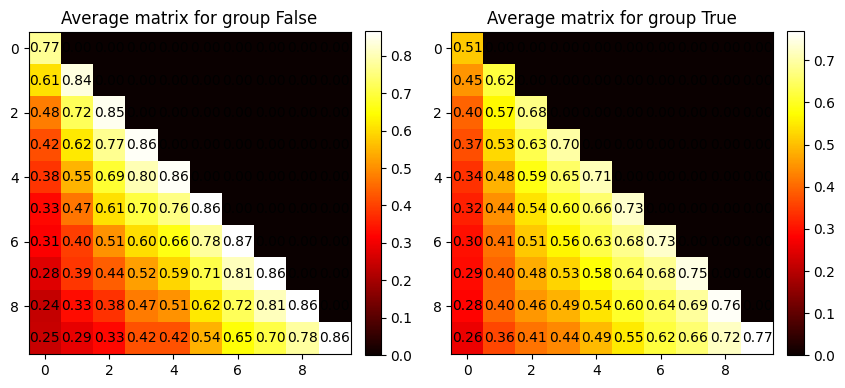

In [3]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import itertools
# Assuming 'group' is the column with group identifiers
group_condition = 'homogeneous_lr'
grouped = df.groupby(group_condition)

# Calculate the average 2D matrix for each group
average_matrices = grouped['performance_mat.p'].apply(lambda g: np.mean(np.array(g.tolist()), axis=0))

# Create a dictionary to store matrices of p-values for each pair of groups
p_values = {}

# Perform t-test on each pair of corresponding elements in the 2D matrices of each pair of groups
for group1, group2 in itertools.combinations(grouped.groups.keys(), 2):
    matrices1 = grouped.get_group(group1)['performance_mat.p'].tolist()
    matrices2 = grouped.get_group(group2)['performance_mat.p'].tolist()

    # Check if the individual matrices within each group have the same dimensions
    if np.shape(matrices1[0]) != np.shape(matrices2[0]):
        print(f"Skipping comparison between group {group1} and group {group2} due to different matrix shapes.")
        continue

    p_val_matrix = np.empty(np.shape(matrices1[0]))
    for i in range(p_val_matrix.shape[0]):
        for j in range(p_val_matrix.shape[1]):
            _, p_val_matrix[i, j] = ttest_ind([mat[i, j] for mat in matrices1], [mat[i, j] for mat in matrices2])

    # Apply Bonferroni correction
    p_val_matrix *= np.size(p_val_matrix)
    p_val_matrix[p_val_matrix > 1] = 1  # cap p-values at 1 after Bonferroni correction

    p_values[(group1, group2)] = p_val_matrix

#  Plot the average matrices and print the average p-value for each pair of groups
for group1, group2 in p_values.keys():
    print(f"Comparison between group {group1} and group {group2}:")
    print(f"Average corrected p-value: {np.mean(p_values[(group1, group2)])}")

    # Plot the average matrices
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im1 = axs[0].imshow(average_matrices.loc[group1], cmap='hot', interpolation='nearest')
    axs[0].set_title(f'Average matrix for group {group1}')
    fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)  # Add a colorbar to the first subplot

    # Display average values on each entry of the matrix
    for (j,i),label in np.ndenumerate(average_matrices.loc[group1]):
        axs[0].text(i,j,f"{label:.2f}",ha='center',va='center', color='k')

    im2 = axs[1].imshow(average_matrices.loc[group2], cmap='hot', interpolation='nearest')
    axs[1].set_title(f'Average matrix for group {group2}')
    fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)  # Add a colorbar to the second subplot

    # Display average values on each entry of the matrix
    for (j,i),label in np.ndenumerate(average_matrices.loc[group2]):
        axs[1].text(i,j,f"{label:.2f}",ha='center',va='center', color='k')
    plt.grid(False)
    plt.show()


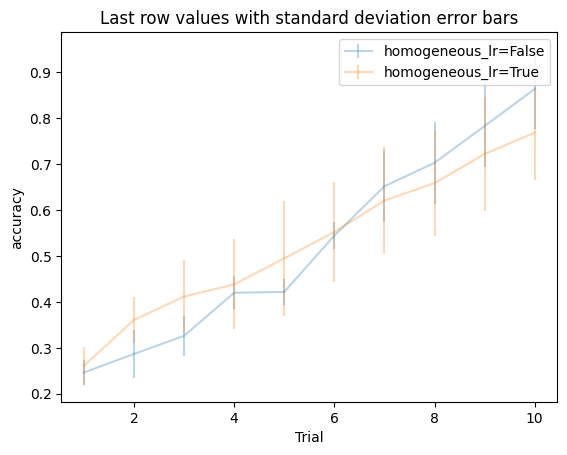

In [4]:
import re

# Extract the last row from each matrix and create a new DataFrame
last_row_df = df.copy()

last_row_df['last_row'] = df['performance_mat.p'].apply(lambda x: x[-1, :])
last_row_df = last_row_df['last_row'].apply(pd.Series)

last_row_df.columns = [f"trial_{i+1}" for i in last_row_df.columns]

# Add the condition columns to the new DataFrame
condition_columns = [group_condition]
for col in condition_columns:
    last_row_df[col] = df[col]

# Melt the DataFrame to a long format suitable for plotting
last_row_df = last_row_df.melt(id_vars=condition_columns, var_name='trial', value_name='accuracy')

# Extract numeric trial number from the 'trial' column
last_row_df['trial'] = last_row_df['trial'].apply(lambda x: int(re.search(r'\d+', x).group()))

# Group by condition and trial
grouped = last_row_df.groupby(condition_columns + ['trial'])
# Calculate mean and std for each group
mean_df = grouped.mean().reset_index()
std_df = grouped.std().reset_index()
# Extract unique group names
group_columns =  df.groupby(condition_columns).size().reset_index().iloc[:, :-1]

# Loop over each unique group
for _, row in group_columns.iterrows():
    condition = pd.Series([True]*len(mean_df))

    # Create a boolean mask for each condition
    for col in condition_columns:
        condition = condition & (mean_df[col] == row[col])

    group_mean_df = mean_df[condition]
    group_std_df = std_df[condition]

    # Create a label for the plot
    label = ', '.join([f'{col}={row[col]}' for col in condition_columns])

    plt.errorbar(group_mean_df['trial'], group_mean_df['accuracy'], yerr=group_std_df['accuracy'], label=label,alpha=0.3)

plt.xlabel('Trial')
plt.ylabel('accuracy')
plt.title('Last row values with standard deviation error bars')
plt.legend()
plt.grid(False)
plt.show()

